
# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=regularization_strength, num_iters=1200,
              batch_size=200, verbose=True)
        y_test_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_test_pred,dtype=np.float32)
        y_val_pred = svm.predict(X_train_feats)
        acc_train = np.mean(y_train == y_val_pred, dtype=np.float32)
        results[(learning_rate, regularization_strength)] = acc_train, acc_val
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1200: loss 88.594747
iteration 100 / 1200: loss 87.017902
iteration 200 / 1200: loss 85.477300
iteration 300 / 1200: loss 83.964523
iteration 400 / 1200: loss 82.473301
iteration 500 / 1200: loss 81.039567
iteration 600 / 1200: loss 79.597908
iteration 700 / 1200: loss 78.202244
iteration 800 / 1200: loss 76.834873
iteration 900 / 1200: loss 75.479437
iteration 1000 / 1200: loss 74.181832
iteration 1100 / 1200: loss 72.877209
iteration 0 / 1200: loss 782.243129
iteration 100 / 1200: loss 642.012834
iteration 200 / 1200: loss 527.225576
iteration 300 / 1200: loss 433.239796
iteration 400 / 1200: loss 356.301540
iteration 500 / 1200: loss 293.311244
iteration 600 / 1200: loss 241.750958
iteration 700 / 1200: loss 199.541749
iteration 800 / 1200: loss 164.990267
iteration 900 / 1200: loss 136.700830
iteration 1000 / 1200: loss 113.543736
iteration 1100 / 1200: loss 94.579343
iteration 0 / 1200: loss 7553.419160
iteration 100 / 1200: loss 1019.803361
iteration 200 / 1200: los

In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.406


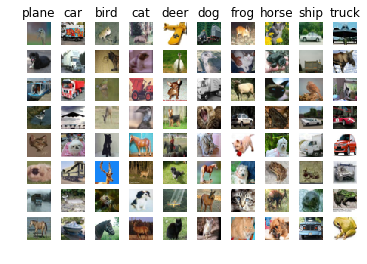

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$The outlines or colors of the misclassification results are similar to the class to which they were classified.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [24]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 开始发现损失降低太慢，考虑原先的学习率选择太小，后来发现学习率加大到0.1后仍然损失下降很慢，考虑正则项的系数是否太大
bestacc = 0
for learning_rate in [1e-1, 2e-1]:
    for learning_rate_decay in [0.95, 0.99]:
        for reg in [3e-4,1e-3,3e-3]:
            for batch_size in [200, 500, 600]:
                # Train the network
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=3000, batch_size=batch_size,
                            learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
                            reg=reg, verbose=True)

                # Predict on the validation set
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                
                if bestacc<val_acc:
                    bestacc = val_acc
                    best_net = net
                print('hidden_size = %d,learning_rate = %f,learning_rate_decay = %f,reg = %f,,batch_size = %d,\
                      Validation accuracy =%f, Best acc = %f '%(hidden_dim,learning_rate,learning_rate_decay,reg,
                                                          batch_size,val_acc, bestacc))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.303901
iteration 200 / 3000: loss 2.145214
iteration 300 / 3000: loss 1.841733
iteration 400 / 3000: loss 1.631220
iteration 500 / 3000: loss 1.445364
iteration 600 / 3000: loss 1.428340
iteration 700 / 3000: loss 1.410419
iteration 800 / 3000: loss 1.423529
iteration 900 / 3000: loss 1.358661
iteration 1000 / 3000: loss 1.453628
iteration 1100 / 3000: loss 1.348420
iteration 1200 / 3000: loss 1.258272
iteration 1300 / 3000: loss 1.226238
iteration 1400 / 3000: loss 1.309011
iteration 1500 / 3000: loss 1.278273
iteration 1600 / 3000: loss 1.208457
iteration 1700 / 3000: loss 1.257348
iteration 1800 / 3000: loss 1.261706
iteration 1900 / 3000: loss 1.291772
iteration 2000 / 3000: loss 1.369469
iteration 2100 / 3000: loss 1.234803
iteration 2200 / 3000: loss 1.364335
iteration 2300 / 3000: loss 1.212764
iteration 2400 / 3000: loss 1.145362
iteration 2500 / 3000: loss 1.227103
iteration 2600 / 3000: loss 1.189030
iteration 270

iteration 1500 / 3000: loss 1.279155
iteration 1600 / 3000: loss 1.318095
iteration 1700 / 3000: loss 1.307728
iteration 1800 / 3000: loss 1.476858
iteration 1900 / 3000: loss 1.323919
iteration 2000 / 3000: loss 1.373089
iteration 2100 / 3000: loss 1.304020
iteration 2200 / 3000: loss 1.265153
iteration 2300 / 3000: loss 1.313945
iteration 2400 / 3000: loss 1.308692
iteration 2500 / 3000: loss 1.308542
iteration 2600 / 3000: loss 1.414301
iteration 2700 / 3000: loss 1.368467
iteration 2800 / 3000: loss 1.226503
iteration 2900 / 3000: loss 1.248679
hidden_size = 500,learning_rate = 0.100000,learning_rate_decay = 0.950000,reg = 0.003000,,batch_size = 200,                      Validation accuracy =0.594000, Best acc = 0.607000 
iteration 0 / 3000: loss 1.284890
iteration 100 / 3000: loss 1.307984
iteration 200 / 3000: loss 1.269499
iteration 300 / 3000: loss 1.259171
iteration 400 / 3000: loss 1.337924
iteration 500 / 3000: loss 1.302183
iteration 600 / 3000: loss 1.311795
iteration 700 

hidden_size = 500,learning_rate = 0.100000,learning_rate_decay = 0.990000,reg = 0.001000,,batch_size = 200,                      Validation accuracy =0.587000, Best acc = 0.607000 
iteration 0 / 3000: loss 0.931833
iteration 100 / 3000: loss 0.906321
iteration 200 / 3000: loss 0.897733
iteration 300 / 3000: loss 0.891639
iteration 400 / 3000: loss 0.932464
iteration 500 / 3000: loss 0.917022
iteration 600 / 3000: loss 0.928997
iteration 700 / 3000: loss 0.895510
iteration 800 / 3000: loss 0.924667
iteration 900 / 3000: loss 0.848222
iteration 1000 / 3000: loss 0.851994
iteration 1100 / 3000: loss 0.905384
iteration 1200 / 3000: loss 0.904505
iteration 1300 / 3000: loss 0.878671
iteration 1400 / 3000: loss 0.896064
iteration 1500 / 3000: loss 0.886958
iteration 1600 / 3000: loss 0.892825
iteration 1700 / 3000: loss 0.885473
iteration 1800 / 3000: loss 0.896690
iteration 1900 / 3000: loss 0.908144
iteration 2000 / 3000: loss 0.890898
iteration 2100 / 3000: loss 0.878515
iteration 2200 / 

iteration 1000 / 3000: loss 0.584227
iteration 1100 / 3000: loss 0.570332
iteration 1200 / 3000: loss 0.628317
iteration 1300 / 3000: loss 0.559571
iteration 1400 / 3000: loss 0.523640
iteration 1500 / 3000: loss 0.571462
iteration 1600 / 3000: loss 0.567559
iteration 1700 / 3000: loss 0.545345
iteration 1800 / 3000: loss 0.554332
iteration 1900 / 3000: loss 0.530235
iteration 2000 / 3000: loss 0.543806
iteration 2100 / 3000: loss 0.575137
iteration 2200 / 3000: loss 0.513523
iteration 2300 / 3000: loss 0.599482
iteration 2400 / 3000: loss 0.604280
iteration 2500 / 3000: loss 0.568212
iteration 2600 / 3000: loss 0.575213
iteration 2700 / 3000: loss 0.524385
iteration 2800 / 3000: loss 0.544181
iteration 2900 / 3000: loss 0.562644
hidden_size = 500,learning_rate = 0.200000,learning_rate_decay = 0.950000,reg = 0.000300,,batch_size = 500,                      Validation accuracy =0.575000, Best acc = 0.607000 
iteration 0 / 3000: loss 0.551501
iteration 100 / 3000: loss 0.576017
iteration

iteration 2500 / 3000: loss 1.261804
iteration 2600 / 3000: loss 1.228986
iteration 2700 / 3000: loss 1.294782
iteration 2800 / 3000: loss 1.261367
iteration 2900 / 3000: loss 1.260109
hidden_size = 500,learning_rate = 0.200000,learning_rate_decay = 0.950000,reg = 0.003000,,batch_size = 500,                      Validation accuracy =0.608000, Best acc = 0.608000 
iteration 0 / 3000: loss 1.291807
iteration 100 / 3000: loss 1.267713
iteration 200 / 3000: loss 1.259573
iteration 300 / 3000: loss 1.254734
iteration 400 / 3000: loss 1.320043
iteration 500 / 3000: loss 1.285329
iteration 600 / 3000: loss 1.262332
iteration 700 / 3000: loss 1.215837
iteration 800 / 3000: loss 1.310903
iteration 900 / 3000: loss 1.287017
iteration 1000 / 3000: loss 1.251457
iteration 1100 / 3000: loss 1.228692
iteration 1200 / 3000: loss 1.315860
iteration 1300 / 3000: loss 1.229600
iteration 1400 / 3000: loss 1.241415
iteration 1500 / 3000: loss 1.257608
iteration 1600 / 3000: loss 1.279080
iteration 1700 / 

iteration 500 / 3000: loss 0.912923
iteration 600 / 3000: loss 0.887138
iteration 700 / 3000: loss 0.895173
iteration 800 / 3000: loss 0.893362
iteration 900 / 3000: loss 0.841154
iteration 1000 / 3000: loss 0.889673
iteration 1100 / 3000: loss 0.906831
iteration 1200 / 3000: loss 0.872692
iteration 1300 / 3000: loss 0.878869
iteration 1400 / 3000: loss 0.855922
iteration 1500 / 3000: loss 0.911894
iteration 1600 / 3000: loss 0.870037
iteration 1700 / 3000: loss 0.810867
iteration 1800 / 3000: loss 0.862684
iteration 1900 / 3000: loss 0.852583
iteration 2000 / 3000: loss 0.928797
iteration 2100 / 3000: loss 0.877345
iteration 2200 / 3000: loss 0.878661
iteration 2300 / 3000: loss 0.836365
iteration 2400 / 3000: loss 0.897144
iteration 2500 / 3000: loss 0.874921
iteration 2600 / 3000: loss 0.903912
iteration 2700 / 3000: loss 0.922958
iteration 2800 / 3000: loss 0.878906
iteration 2900 / 3000: loss 0.902295
hidden_size = 500,learning_rate = 0.200000,learning_rate_decay = 0.990000,reg = 

In [25]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.58
